# Analisis de datos 

__En la primer casilla se vuelcan los datos y se hacen los import necesarios__

__Es necesario ejecutarla para poder hacer el resto__




In [20]:
import os
import pandas as pd
import datetime
import random
from matplotlib import pyplot as plt
%matplotlib inline

registro = os.path.join(os.getcwd(), "data", "registro_ejemplo.csv")

data_set = pd.read_csv(registro, encoding="utf-8")

data_set

,timestamp,id,evento,usuarie,estado,texto ingresado,respuesta,nivel
0,1654492780,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
1,1654632898,bd7f4ee8-e53f-11ec-8fea-0242ac120002,intento,sofi,error,Cristiano Ronaldo,Lionel Messi,normal
2,1654632999,6c1bae73-a8d8-4ded-97db-636d59af0ee2,intento,sofi,ok,Lionel Messi,Lionel Messi,normal
3,1654732392,03aea3f6-890c-4194-9613-9c76981083ec,intento,sofi,error,Kylian Mbappé,Alisson,normal
4,1654742291,a1d62ee7-4f35-48a9-9b3e-4fa2f04a6645,intento,sofi,timeout,-,Alisson,normal
5,1654482693,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,sofi,finalizada,-,-,normal
6,1654492780,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
7,1654492780,33ff0802-e53f-11ec-8fea-0242ac120002,inicio_partida,sofi,-,-,-,normal
8,1654492780,5fb49e99-53a9-48b1-b103-ecbeae12f581,fin,señor x,timeout,-,-,normal
9,1654742291,a1d62ee7-4f35-48a9-9b3e-4fa2f04a6645,intento,señor x,timeout,-,Alisson,normal


## Definiciones de las funciones que grafican:
__tambien hay que ejecutar esto para que ande todo__

In [64]:
def dibujito_torta(etiquetas, datos_dibujo, titulo, explota = (0.1), bbox = (1.2, 0.9)):
    """Hace un dibujo tipo torta con los datos que le pasas"""
    explode = tuple([explota for x in datos_dibujo])

    plt.pie(datos_dibujo, explode=explode, labels=etiquetas, autopct='%1.2f%%',
    shadow=True, startangle=90, labeldistance= 1.1)

    plt.axis('equal')
    plt.legend(etiquetas, loc=1, bbox_to_anchor=bbox)
    plt.title(titulo)
    plt.show()

def dibujito_barra(llaves, valores, titulo, size = (6,6), prcnt = ""):
    colores = [
            "Red", "Orange", "Purple", "Pink",
            "Yellow", "Blue", "Green", "bisque",
            "aqua", "magenta", "peru", "firebrick",
            "sienna", "gold", "deeppink"
          ]
    plt.figure(figsize=size)
    lista_colores = [random.choice(colores) for i in llaves]                  
    graph = plt.bar(llaves, valores, color = lista_colores)
    plt.title(titulo)
    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*1.01,
                 str(list(valores)[i]) +prcnt,
                 ha='center',
                 weight='bold')
        i += 1
    plt.show()

## 1) Top 10 primeras palabras que se encuentran en las partidas:

# no se me ocurrio una mejor manera, se escuchan sugerencias.

# falta contarlas, pero tambien faltan los datos.

1. Saca todos los datos que no importan.
<br><br>
2. Itera para sacar el 1er "ok" de cada partida.
<br><br>
3. Usamos el evento "inicio_partida" para separarlas.

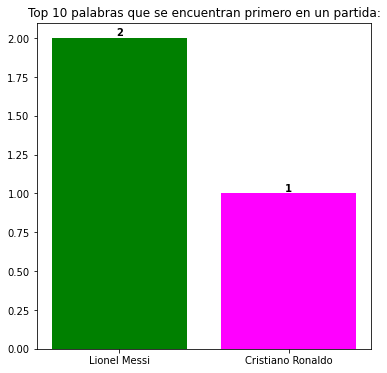

In [49]:
data_frame = data_set.drop(["timestamp", "id", "usuarie", "texto ingresado", "nivel"], axis="columns")
data_frame = data_frame.drop(data_frame[data_frame.estado == "error"].index)
data_frame = data_frame.drop(data_frame[data_frame.estado == "timeout"].index)

nueva = True
lista_palabras = []

for row in data_frame.itertuples():
    evento = getattr(row, "evento")
    estado = getattr(row, "estado")
    if evento == "inicio_partida":
        nueva = True
    if nueva and estado == "ok":
        lista_palabras.append(getattr(row, "respuesta"))
        nueva = False

df_new = pd.DataFrame(lista_palabras, columns=["Palabras"])
serie = df_new.groupby("Palabras").size()
serie = serie.sort_values(ascending=False).head(10)

dibujito_barra(serie.index, serie.values, "Top 10 palabras que se encuentran primero en un partida:")

## 2) Grafico de partidas finalizadas por estado:

__pido perdon por ese for__

# acordate de modificar esto en el futuro cercano

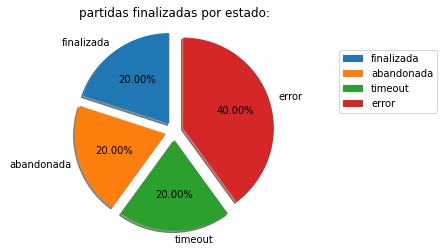

In [21]:
df = data_set.loc[:, ["evento", "estado"]]
df = df.drop(df[df.evento == "intento"].index)

cant_error = 0
nueva = False

for row in df.itertuples():
    evento = getattr(row, "evento")
    if nueva and evento == "inicio_partida":
        cant_error += 1
    elif evento == "inicio_partida":
        nueva = True
    elif evento == "fin":
        nueva = False
if nueva:
    cant_error += 1

df = df[df["evento"] == "fin"]
df = df.groupby(["estado"]).size()

etiquetas = ["finalizada", "abandonada", "timeout", "error"]

datos_dibujo = []
for key in etiquetas[:-1]:
    datos_dibujo.append(df[key] if key in df.index else 0)
datos_dibujo.append(cant_error)

dibujito_torta(etiquetas, datos_dibujo, "partidas finalizadas por estado:", bbox=(1.3, 0.9))

## 3) Grafico de partidas finalizadas segun genero:

# acordate de meter un metodo en perfiles para no romper encapsulamiento

1. pido los datos de los usuarios, para poder hacer la conexion nombre/genero.
<br><br> 
2. separo todos los eventos de fin.
<br><br>
3. enmascaro los datos para cambiar nombre por el genero autopercibido.
<br><br>
4. paso los datos a la figurita.

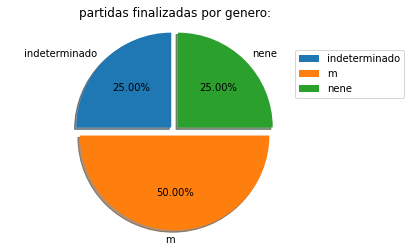

In [12]:
from json import load as jload
from jugadores import carga_analisy as cargar

usuarios = cargar()
    
df = data_set[data_set["evento"] == "fin"]
# Si no hago la copia me tira un cartelito rojo
df1 = df.copy()
df1["usuarie"]= df["usuarie"].apply(lambda x: usuarios[x][1] if x in usuarios.keys() else "indeterminado")

nuevo = df1.groupby(["usuarie"]).size()

etiquetas = nuevo.index.unique()
etiquetas = list(etiquetas)

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(nuevo[key])

dibujito_torta(etiquetas, datos_dibujo, "partidas finalizadas por genero:", (0.05))

## 4) Grafico de las partidas finalizadas segun nivel:

__me quedó la duda de si poner en el grafico las dificultades que no tienen partida ó no__

__las terminé agregando__

1. separo las partidas que finalizaron.
<br><br>
2. las agrupo por nivel y mando al grafico.

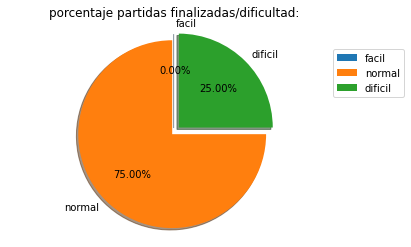

In [24]:
df = data_set[data_set["evento"] == "fin"]
df = df.groupby(["nivel"]).size()

etiquetas = ["facil", "normal", "dificil"]

datos_dibujo = []
for key in etiquetas:
    datos_dibujo.append(df[key] if key in df.index else 0)

dibujito_torta(etiquetas, datos_dibujo, "porcentaje partidas finalizadas/dificultad:", (0.05))

## 5) Duracion total de la partida:

# no se como se calcula en el registro

# pide duracion total de todas las partidas

# en un grafico de puntitos (tipo garfico de toda la vida)

# hay que testear una vez que completemos el registro

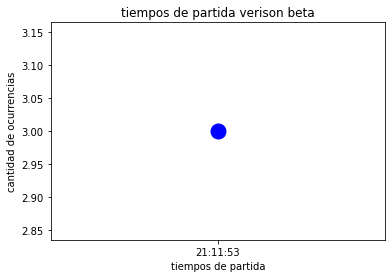

In [57]:
def sacar_tiempo(inicio, fin):
    if inicio > fin:
        respuesta = pd.Timedelta(fin - inicio).total_seconds()
    else:
        respuesta = pd.Timedelta(inicio - fin).total_seconds()
    
    if respuesta > 0:
        return (str(datetime.timedelta(seconds=respuesta)))
    else:
        return (str(datetime.timedelta(seconds=respuesta)))[8:]

df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False

lista = [x for x in lista if x]
lista = list(map(lambda x: pd.Timedelta(x), lista))


x = list(map(lambda x: str(x)[7:], lista))
y = [x.count(elem) for elem in dict.fromkeys(x)]
x = list(dict.fromkeys(x))

plt.xlabel("tiempos de partida")
plt.ylabel("cantidad de ocurrencias")
plt.title("tiempos de partida verison beta")
plt.plot(x, y, 'o', color='Blue', markersize=15, linewidth=3);

## 6) tiempo de la respuesta correcta mas rapida:

# Faltan datos para chequear que anda

# revisar

In [58]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#min(lista)
#faltan datos reales para chequear que funciona

[0.0, 0.0, 0.00014, 0.0]

## 7) Promedio de tiempo de respuesta para respuestas correctas:

# la vida...

# Siguen faltando datos 

In [59]:
data_frame = data_set.drop(["id", "usuarie", "texto ingresado", "nivel"], axis="columns")
df = data_frame.drop(data_frame[data_frame.evento == "fin"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

anterior = 0
lista_tiempos = []

for index, row in data_frame.iterrows():
    if anterior and row["estado"] == "ok":
        lista_tiempos.append(pd.Timedelta(row["timestamp"] - anterior).total_seconds()) 
    anterior = row["timestamp"]
    
lista_tiempos

#igual que el anterior, pero sumas todo y dividis por len(lista)
# ...
# creo

[0.0, 0.0, 0.00014, 0.0]

## 8) Promedio de tiempo de partida general:

# separador

In [155]:
def sacar_tiempo(inicio, fin):
    if inicio > fin:
        respuesta = pd.Timedelta(fin - inicio).total_seconds()
    else:
        respuesta = pd.Timedelta(inicio - fin).total_seconds()
    
    if respuesta > 0:
        return (str(datetime.timedelta(seconds=respuesta)))
    else:
        return (str(datetime.timedelta(seconds=respuesta)))[8:]

df = data_set.drop(data_set[data_set.evento == "intento"].index)
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

tempo = 0
partida = True
lista = []

for index, row in df.iterrows():
    if row["evento"] == "inicio_partida":
        tempo = row["timestamp"]
        partida = True
    elif row["evento"] == "fin" and partida:
        lista.append(sacar_tiempo(tempo,row["timestamp"]))
        partida = False

lista = [x for x in lista if x]
lista = list(map(lambda x: pd.Timedelta(x), lista))

average = 0
for date in lista:
    average += date.total_seconds()

str(datetime.timedelta(seconds=average/len(lista)))

#igual que el de 2 veces arriba, no entiendo la diferencia conceptual de cada uno
# preguntar en la consulta

'21:11:53'

## 9) Porcentaje de acierto por usuarie:

# necesitaria ampliar el registro_ejemplo para esto

# 

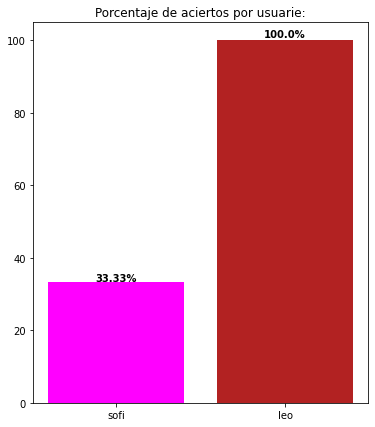

In [34]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo and "ok" in nuevo[nombre].keys():
        aux = (nuevo[nombre].ok / nuevo[nombre].sum()) * 100
        result[nombre] = (round((aux), 2))
        
dibujito_barra(result.keys(), result.values(), "Porcentaje de aciertos por usuarie:", (6,7), "%")

## 10) Cantidad de tarjetas para las que el usuarie no dió respuesta (timeout):

# Taria bueno un registro

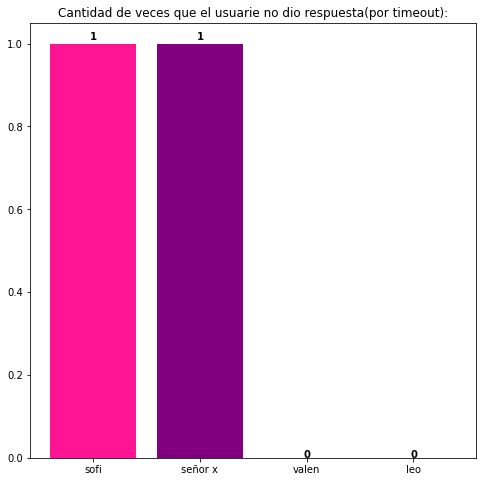

In [35]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "timeout"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()


result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].timeout
    else:
        result[nombre] = 0
        
dibujito_barra(result.keys(), result.values(), "Cantidad de veces que el usuarie no dio respuesta(por timeout):", (8,8))

## 11) Cantidad de tarjetas en las que el usuarie dió una respuesta errónea:

# lo mismo que el anterior

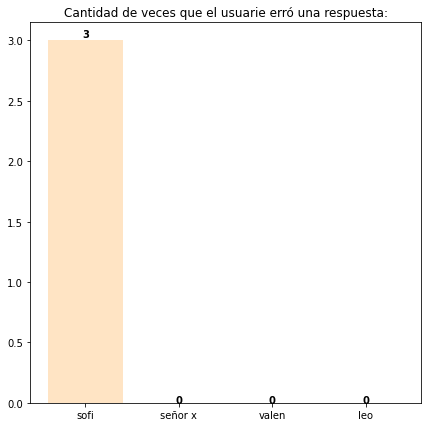

In [63]:
df = data_set.drop(data_set[data_set.evento != "intento"].index)
usuarios = data_set["usuarie"].unique()
df = df.drop(df[df.estado != "error"].index)
nuevo = df.groupby(["usuarie", "estado"]).size()

result = {}

for nombre in usuarios:
    if nombre in nuevo:
        result[nombre] = nuevo[nombre].error
    else:
        result[nombre] = 0
        
dibujito_barra(result.keys(), result.values(), "Cantidad de veces que el usuarie erró una respuesta:", (7,7))